<a href="https://colab.research.google.com/github/IshtiSikder/Optimal-allocation-of-rescue-teams-for-hostage-situations/blob/updates/R_for_MDP_(NEW).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prob function: 

Calculates steady state probabilities for given number of maximum possible hostage incidents in the system and given rescue team deployment policy.

In [93]:
prob <- function(opSet = policySet, t, lam, eps, mu) {
  
  ############################################################################################################################
  cat('############################ prob() FUNCTION INITIATED #####################################','\n\n')
  cat('[Input to prob()] GIVEN POLICY SET (opSET):','\n\n')
  print(opSet)
  cat('\n')
  cat('[Input to prob()] GIVEN NUMBER OF MAX POSSIBLE HOSTAGE INCIDENTS IN THE SYSTEM, t:',t,'\n\n')
  cat('[Input to prob()] GIVEN ARRIVAL RATE FOR HOSTAGE INCIDENTS, lam:',lam,'\n\n')
  cat('[Input to prob()] GIVEN SERVICE RATE FOR HOSTAGE INCIDENTS, eps:',eps,'\n\n')
  cat('[Input to prob()] GIVEN SERVICE RATE FOR RESCUE OPERATIONS,mu:',mu,'\n\n')
  cat('==>>> ZERO TRANSITION MATRIX (opTRM) IS CREATED WITH DIMENSION (t+1,t+1)):\n\n')
  ############################################################################################################################

  #CODE
  opTRM = matrix(0, nrow = t+1, ncol = t+1)

  ############################################################################################################################
  print(opTRM)
  cat('\n')
  cat('==>>> FOR i IN 2 TO t:\n\n')
  cat('opTRM[i, i-1] = i*eps + opSet[i]*mu\n')
  cat('opTRM[i, i+1] = lam ','\n\n')
  ############################################################################################################################
  
  #CODE
  for (i in 2:t) {
    opTRM[i, i-1] = sum(i*eps, opSet[i]*mu)
    opTRM[i, i+1] = lam    
  }

  opTRM[1, 2] = lam
  opTRM[t+1, t] = sum(t*eps, opSet[t+1]*mu)


  ############################################################################################################################
  rand <- sample(2:t,1)
  cat('RANDOM EXAMPLE: WHEN i=',rand,'\n')
  cat('opTRM[',rand,',', rand-1,'] =', rand,'*',eps,'+(opSet[',rand,']=)',opSet[rand],'*',mu,'=',opTRM[rand, rand-1],'\n')
  cat('opTRM[',rand,',',rand+1,']=',opTRM[rand, rand+1],'\n\n') 

  cat('==>>> opTRM[1, 2] = (lam=)',opTRM[1, 2],'\n\n')
  cat('==>>> opTRM[t+1, t] = t*eps + opSet[t+1]*mu','\n')
  cat('opTRM[',t+1,',', t,'] =', t,'*',eps,'+','(opSet[',t+1,']=)',opSet[t+1],'*',mu,'=',opTRM[t+1, t],'\n\n')  
  cat('Final opTRM:','\n\n')
  print(opTRM)
  cat('\n\n')
  ############################################################################################################################

  #CODE
  k = t+1

  ############################################################################################################################
  cat('==>>> k = t+1=',k,'\n\n')
  ############################################################################################################################

  #CODE
  steady_prob <- matrix(0, nrow=1, ncol=k)

  ############################################################################################################################
  cat('==>>> ZERO MATRIX (steady_prob) IS CREATED WITH DIMENSION (1,k)):\n\n')
  print(steady_prob)
  cat('\n\n')
  ############################################################################################################################

  #CODE
  state <- matrix(0, nrow=1, ncol=k-1)

  ############################################################################################################################
  cat('==>>> ZERO MATRIX (steady) IS CREATED WITH DIMENSION (1,k-1)):\n\n')
  print(state)
  cat('\n\n')
  ############################################################################################################################

  #CODE
  for (i in 1:(k-1)) {
    if (i-2 < 0) {
      state[i] <- (lam/opTRM[i+1,i])
    } else {
      state[i] <- state[i-1]*(lam/opTRM[i+1,i])
    }
  }

 ############################################################################################################################
 cat('==>>> FOR i in 1 to k-1:\n')
 cat('if i-2>0, state[i] = lam/opTRM[i+1,i]','\n')
 cat('if i-2<=0, state[i] = state[i-1]*(lam/opTRM[i+1,i]','\n\n')
 for (rand_2 in 1:k-1){
 cat('RANDOM EXAMPLE: i=',rand_2,'\n')
 if (rand_2-2>0){cat(rand_2,'- 2 =',rand_2-2,'>0,','state[',rand_2,'] = ',lam,'/','(opTRM[',rand_2+1,',',rand_2,'] =)',opTRM[rand_2+1,rand_2],'=',state[rand_2],'\n')}
 else {cat(rand_2,'- 2 =',rand_2-2,'<=0,',state[(rand_2)-1])}}
 
 #',state[',rand_2,'] = (state[',rand_2-1,']=)',state[(rand_2)-1],'*(',lam,'/(opTRM[',rand_2+1,',',rand_2,']=)',opTRM[rand_2+1,rand_2],')=',state[rand_2],'\n\n'))}

  
  steady_prob[1] <- (1+sum(state))^-1
  for (i in 2:k) {
    steady_prob[i] <- state[i-1]*steady_prob[1]
  }
  return(steady_prob)
}

In [94]:
prob(opSet=array(2,dim=c(1,11)),t=10,lam = 0.2763, mu = 0.2829, eps = 0.1718)

############################ prob() FUNCTION INITIATED ##################################### 

[Input to prob()] GIVEN POLICY SET (opSET): 

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
[1,]    2    2    2    2    2    2    2    2    2     2     2

[Input to prob()] GIVEN NUMBER OF MAX POSSIBLE HOSTAGE INCIDENTS IN THE SYSTEM, t: 10 

[Input to prob()] GIVEN ARRIVAL RATE FOR HOSTAGE INCIDENTS, lam: 0.2763 

[Input to prob()] GIVEN SERVICE RATE FOR HOSTAGE INCIDENTS, eps: 0.1718 

[Input to prob()] GIVEN SERVICE RATE FOR RESCUE OPERATIONS,mu: 0.2829 

==>>> ZERO TRANSITION MATRIX (opTRM) IS CREATED WITH DIMENSION (t+1,t+1)):

      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
 [1,]    0    0    0    0    0    0    0    0    0     0     0
 [2,]    0    0    0    0    0    0    0    0    0     0     0
 [3,]    0    0    0    0    0    0    0    0    0     0     0
 [4,]    0    0    0    0    0    0    0    0    0     0     0
 [5,]    0    0    0    0    0    0

0.7129669,0.2166184,0.05535669,0.01220675,0.002367156,0.0004096488,6.400473e-05,9.114786e-06,1.192431e-06,1.442634e-07,1.745336e-08


In [95]:
for (i in 1:10){print(i)}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10


In [96]:
checkPolicy = function(policySet, policySetnew) {
  cat('############################ checkPolicy() FUNCTION INITIATED #####################################','\n\n')
  n = 0
  cat('[Input to checkPolicy()] policySet:','\n\n')
  print(policySet)
  cat('\n\n')
  cat('[Input to checkPolicy()] policySetnew:','\n\n')
  print(policySetnew)
  cat('\n\n')
  cat('[checkPolicy() FUNCTION TERMINATES] ==>> ARE BOTH POLICIES THE SAME?')
  for (i in policySet == policySetnew) {
    if (i == 'FALSE') {
      n = 1
    } 
  } 
  if (n == 0) {
    return('TRUE')
  } else {
    return('FALSE')
  }
} 

In [97]:
checkPolicy(array(2,dim=c(1,11)),array(2,dim=c(1,11)))

############################ checkPolicy() FUNCTION INITIATED ##################################### 

[Input to checkPolicy()] policySet: 

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
[1,]    2    2    2    2    2    2    2    2    2     2     2


[Input to checkPolicy()] policySetnew: 

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
[1,]    2    2    2    2    2    2    2    2    2     2     2


[checkPolicy() FUNCTION TERMINATES] ==>> ARE BOTH POLICIES THE SAME?

[1] "TRUE"

In [98]:
rewardR <- function(costR, RC, nr) {
  cat('############################ rewardR() FUNCTION INITIATED #####################################','\n\n')

  cat('[Input to rewardR()]: COST OF DEPLOYING A RESCUE TEAM, costR:',costR,'\n\n')
  cat('[Input to rewardR()]: COST STRUCTURE FOR RESCUE, RC:',RC,'\n\n')
  cat('[Input to rewardR()]: NUMBER OF RESCUE TEAMS DEPLOYED, nr:',nr,'\n\n')
  if (RC == "SR") {
    if (costR < 0) {
      cat('[rewardR() FUNCTION TERMINATES] ==>>> costR < 0','\n\n')
      result = -sqrt(-costR * nr)  
      cat('result = -sqrt(-costR * nr) = -sqrt(',-costR,'*', nr,') =','\n\n')    
    } else {
      cat('[rewardR() FUNCTION TERMINATES] ==>>> costR >= 0','\n\n')
      result = sqrt(costR * nr)
      cat('result = sqrt(costR * nr) = sqrt(',costR,'*', nr,') =','\n\n')
    }
  } else if (RC == "L") {
    result = costR * nr   
    cat('[rewardR() FUNCTION TERMINATES] ==>>> result = costR * nr = ',costR,'*', nr,' =','\n\n')   
  } else {
    if (costR < 0) {
      cat('[rewardR() FUNCTION TERMINATES] ==>>> costR < 0','\n\n')
      result = -(costR * nr)^2  
      cat('result = -(costR * nr)^2  = -(',costR,'*', nr,')^2 =','\n\n')    
    } else {
      cat('[rewardR() FUNCTION TERMINATES] ==>>> costR >= 0','\n\n')
      result = (costR * nr)^2 
      cat('result = (costR * nr)^2 = (',costR,'*', nr,')^2 =','\n\n')     
    }
  }
  return(result)
}

In [99]:
rewardR(1,'SR',10)

############################ rewardR() FUNCTION INITIATED ##################################### 

[Input to rewardR()]: COST OF DEPLOYING A RESCUE TEAM, costR: 1 

[Input to rewardR()]: COST STRUCTURE FOR RESCUE, RC: SR 

[Input to rewardR()]: NUMBER OF RESCUE TEAMS DEPLOYED, nr: 10 

[rewardR() FUNCTION TERMINATES] ==>>> costR >= 0 

result = sqrt(costR * nr) = sqrt( 1 * 10 ) = 



[1] 3.162278

In [100]:
rewardT <- function(costT, TC, nt) {
  cat('############################ rewardT() FUNCTION INITIATED #####################################','\n\n')
  cat('[Input to rewardT()]: COST OF HOSTAGE INCIDENTS, costT:',costT,'\n\n')
  cat('[Input to rewardT()]: COST STRUCTURE FOR HOSTAGE INCIDENTS, TC:',TC,'\n\n')
  cat('[Input to rewardT()]: NUMBER OF HOSTAGE INCIDENTS INCURRED, nt:',nt,'\n\n')
  if (TC == "SR") {
    if (costT < 0) {
      cat('[rewardT() FUNCTION TERMINATES] ==>>> costT < 0','\n\n')
      result = -sqrt(-costT * nt)  
      cat('result = -sqrt(-costT * nt) = -sqrt(',-costT,'*', nt,') =','\n\n')    
    } else {
      cat('[rewardT() FUNCTION TERMINATES] ==>>> costT >= 0','\n\n')
      result = sqrt(costT * nt)
      cat('result = sqrt(costT * nt) = sqrt(',costT,'*', nt,') =','\n\n')
    }
  } else if (TC == "L") {
    result = costT * nt
    cat('[rewardT() FUNCTION TERMINATES] ==>>> result = costT * nt = ',costT,'*', nt,' =','\n\n')       
  } else {
    if (costT < 0) {
      cat('[rewardT() FUNCTION TERMINATES] ==>>> costT < 0','\n\n')
      result = -(costT * nt)^2  
      cat('result = -(costT * nt)^2  = -(',-costT,'*', nt,')^2 =','\n\n')    
    } else {
      result = (costT * nt)^2
      cat('[rewardT() FUNCTION TERMINATES] ==>>> costT >= 0','\n\n')
      cat('result = (costT * nt)^2 = (',costT,'*', nt,')^2 =','\n\n')      
    }
  }
  return(result)
}

In [101]:
rewardT(-1,'SR',10)

############################ rewardT() FUNCTION INITIATED ##################################### 

[Input to rewardT()]: COST OF HOSTAGE INCIDENTS, costT: -1 

[Input to rewardT()]: COST STRUCTURE FOR HOSTAGE INCIDENTS, TC: SR 

[Input to rewardT()]: NUMBER OF HOSTAGE INCIDENTS INCURRED, nt: 10 

[rewardT() FUNCTION TERMINATES] ==>>> costT < 0 

result = -sqrt(-costT * nt) = -sqrt( 1 * 10 ) = 



[1] -3.162278

In [102]:
probR = function(nr, nt, eps, mu) {
  cat('############################ probR() FUNCTION INITIATED #####################################','\n\n')
  cat('[Input to probR()]: NUMBER OF RESCUE TEAMS DEPLOYED, nr:',nr,'\n\n')
  cat('[Input to probR()]: NUMBER OF HOSTAGE INCIDENTS INCURRED, nt:',nt,'\n\n')
  cat('[Input to probR()]: NUMBER OF HOSTAGE INCIDENTS INCURRED, nt:',nt,'\n\n')
  #if (nt == 0 & nr == 0) {
  if (nt == 0){
    cat('probR() FUNCTION TERMINATES] ==>>> nt = 0','\n\n')
    result = 0
  } else {
    result = min(nr,nt)*mu / (min(nr,nt)*mu + nt*eps)
  }
  return(result)
}

############################ checkPolicy() FUNCTION INITIATED ##################################### 

[Input to checkPolicy()] policySet: 

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
[1,]    0    0    0    0    0    0    0    0    0     0     0


[Input to checkPolicy()] policySetnew: 

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
[1,]    2    2    2    2    2    2    2    2    2     2     2


[checkPolicy() FUNCTION TERMINATES] ==>> ARE BOTH POLICIES THE SAME?############################ rewardR() FUNCTION INITIATED ##################################### 

[Input to rewardR()]: COST OF DEPLOYING A RESCUE TEAM, costR: 5 

[Input to rewardR()]: COST STRUCTURE FOR RESCUE, RC: QD 

[Input to rewardR()]: NUMBER OF RESCUE TEAMS DEPLOYED, nr: 1 

[rewardR() FUNCTION TERMINATES] ==>>> costR >= 0 

result = (costR * nr)^2 = ( 5 * 1 )^2 = 

############################ rewardT() FUNCTION INITIATED ##################################### 

[Input to rewardT()]: C

$Iteration
[1] 3

$PolicyChange
     terror 0 terror 1 terror 2 terror 3 terror 4 terror 5 terror 6 terror 7
[1,]        1        1        1        1        1        1        1        1
[2,]        0        0        0        0        1        1        1        1
[3,]        0        0        0        1        1        1        1        1
[4,]        0        0        0        1        1        1        1        1
     terror 8 terror 9 terror 10
[1,]        1        1         1
[2,]        1        1         2
[3,]        1        1         2
[4,]        1        1         2

$Gain
[1] 7.672138 3.778789 3.716006

$SteadyStateProb
             terror 0  terror 1  terror 2   terror 3   terror 4    terror 5
Probability 0.4174762 0.3357063 0.1799683 0.05125784 0.01240261 0.002608542
                terror 6     terror 7     terror 8     terror 9    terror 10
Probability 0.0004851836 8.088832e-05 1.221882e-05 1.687271e-06 2.041303e-07

$Optimal_policy
         terror 0 terror 1 terror 2 terror 3 terror 4 terror 5 terror 6
Decision        0        0        0        1        1        1        1
         terror 7 terror 8 terror 9 terror 10
Decision        1        1        1         2

Streaming output truncated to the last 5000 lines.
[Input to rewardT()]: NUMBER OF HOSTAGE INCIDENTS INCURRED, nt: 6 

[rewardT() FUNCTION TERMINATES] ==>>> result = costT * nt =  1 * 6  = 

############################ rewardR() FUNCTION INITIATED ##################################### 

[Input to rewardR()]: COST OF DEPLOYING A RESCUE TEAM, costR: 1 

[Input to rewardR()]: COST STRUCTURE FOR RESCUE, RC: L 

[Input to rewardR()]: NUMBER OF RESCUE TEAMS DEPLOYED, nr: 10 

[rewardR() FUNCTION TERMINATES] ==>>> result = costR * nr =  1 * 10  = 

############################ rewardT() FUNCTION INITIATED ##################################### 

[Input to rewardT()]: COST OF HOSTAGE INCIDENTS, costT: 1 

[Input to rewardT()]: COST STRUCTURE FOR HOSTAGE INCIDENTS, TC: L 

[Input to rewardT()]: NUMBER OF HOSTAGE INCIDENTS INCURRED, nt: 6 

[rewardT() FUNCTION TERMINATES] ==>>> result = costT * nt =  1 * 6  = 

############################ rewardR() FUNCTION INITIATED ###########################

Warning message:
“Removed 3 rows containing missing values (`geom_line()`).”
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



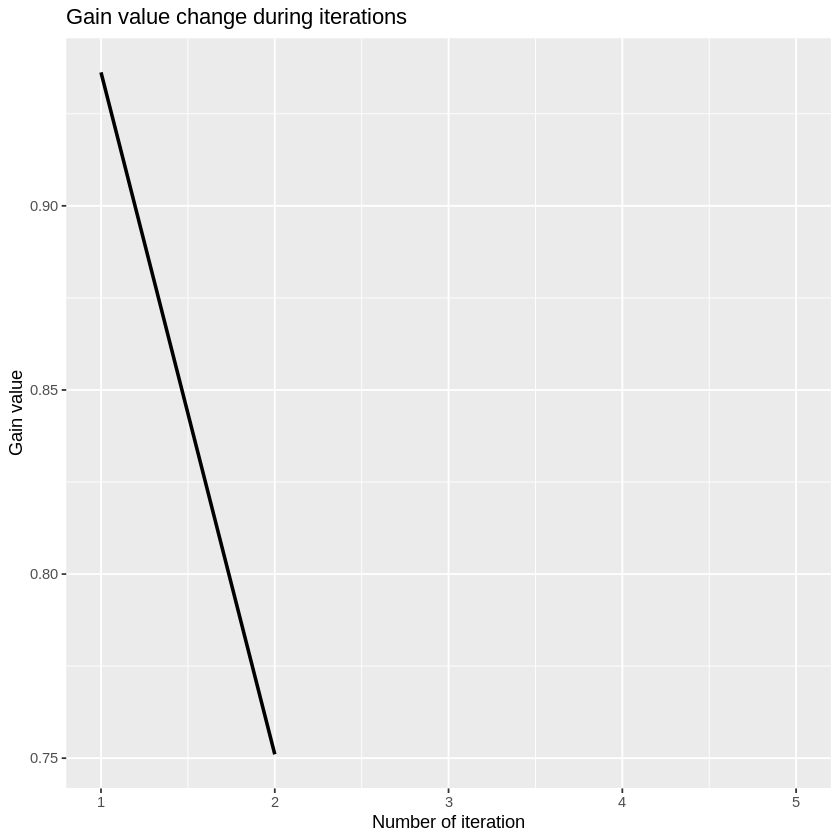

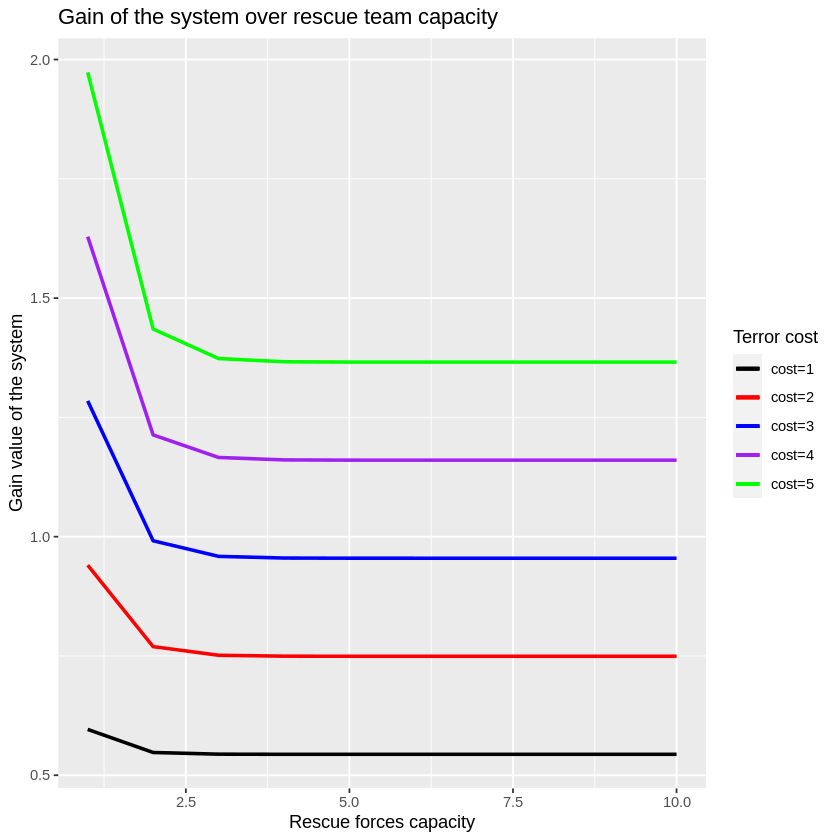

In [103]:
# CTMC MDP model for rescue operational system!!!
# For steady state prob for optimal policy

# prob <- function(opSet = policySet, t, lam, eps, mu) {
#   opTRM = matrix(0, nrow = t+1, ncol = t+1)
#   for (i in 2:t) {
#     opTRM[i, i-1] = sum(i*eps, opSet[i]*mu)
#     opTRM[i, i+1] = lam      
#   }
#   opTRM[1, 2] = lam
#   opTRM[t+1, t] = sum(t*eps, opSet[t+1]*mu)
  
#   k = t+1
#   steady_prob <- matrix(0, nrow=1, ncol=k)
#   state <- matrix(0, nrow=1, ncol=k-1)
#   for (i in 1:(k-1)) {
#     if (i-2 < 0) {
#       state[i] <- (lam/opTRM[i+1,i])
#     } else {
#       state[i] <- state[i-1]*(lam/opTRM[i+1,i])
#     }
#   }
  
#   steady_prob[1] <- (1+sum(state))^-1
#   for (i in 2:k) {
#     steady_prob[i] <- state[i-1]*steady_prob[1]
#   }
#   return(steady_prob)
# }

# Check function to determine new policy is same with current or not 
# checkPolicy = function(policySet, policySetnew) {
#   n = 0
#   for (i in policySet == policySetnew) {
#     if (i == 'FALSE') {
#       n = 1
#     } 
#   } 
#   if (n == 0) {
#     return("TRUE")
#   } else {
#     return("FALSE")
#   }
# } 

# rewardR <- function(costR, RC, nr) {
#   if (RC == "SR") {
#     if (costR < 0) {
#       result = -sqrt(-costR * nr)      
#     } else {
#       result = sqrt(costR * nr)
#     }
#   } else if (RC == "L") {
#     result = costR * nr      
#   } else {
#     if (costR < 0) {
#       result = -(costR * nr)^2      
#     } else {
#       result = (costR * nr)^2      
#     }
#   }
#   return(result)
# }

# rewardT <- function(costT, TC, nt) {
#   if (TC == "SR") {
#     if (costT < 0) {
#       result = -sqrt(-costT * nt)      
#     } else {
#       result = sqrt(costT * nt)
#     }
#   } else if (TC == "L") {
#     result = costT * nt      
#   } else {
#     if (costT < 0) {
#       result = -(costT * nt)^2      
#     } else {
#       result = (costT * nt)^2      
#     }
#   }
#   return(result)
# }

#########################################################
#EDITS: 22ND FEB,2023
#NEW SERVICE RATE STRUCTURE. ADD ORIGINAL ONE AS WELL
probR = function(nr, nt, eps, mu) {
  #if (nt == 0 & nr == 0) {
  if (nt == 0){
    result = 0
  } else {
    result = min(nr,nt)*mu / (min(nr,nt)*mu + nt*eps)
  }
  return(result)
}
#########################################################

# Define MDP function (for basic policy)
MDP = function(lam, mu, eps, numRescue, numTerror, costR, costT, RC, TC) {
  r = numRescue
  t = numTerror
  # Design the three dimension matrix(i,j,k)
  # k: Index of rescue team
  # i: state(current)
  # j: state(next)
  
  
  #########################################################
  #EDITS: 22ND FEB,2023
  #NEW SERVICE RATES STRUCTURE, ADD ORIGINAL ONE AS WELL
  aijMatrix = array(0, dim = c(t+1,t+1,r+1))
  for (k in 1:(r+1)) {
    for (i in 1:t) {
      aijMatrix[i,i+1,k] <- lam
      if (i > 1) {
        #if (k==4){
          #if(i==4){
            #cat('min(k-1,i-1)',min(k-1,i-1))}}
        aijMatrix[i,i-1,k] <- sum(min(k-1,i-1)*mu+(i-1)*eps)        
      }
    }
    aijMatrix[t+1,t,k] <- (min(k-1,t)*mu+t*eps)
    aijMatrix[1,2,k] <- lam
}

  for (k in 1:(r+1)) {
    for (i in 1:(t+1)) {
      
      aijMatrix[i,i,k] <- -sum(aijMatrix[i,,k])      
    }
  }
  #########################################################
  
  #print(aijMatrix[4,4,5])
  #cat('meu',mu)
  #cat('epsilon',eps)
  #break
  
  
  # Design the MDP algorithm
  # Value determination
  policy = array(0, dim = c(1,t+1)) 
  policyOld = array(0, dim = c(1,t+1))
  policyNew = array(2, dim=c(1,t+1)) # initially set all decision is 1 in first policy
  policyTrack = array(2, dim=c(1,t+1))
  iteration = 0
  gainMatrix = c()
  
  while (checkPolicy(policyOld, policyNew) == 'FALSE') {
    policyOld = policyNew
    policy = policyNew
    # Design the transition matrix regarding policy
    A = array(0, dim = c(t+1,t+1))
    for (i in 1:length(policy)) {
      A[i,] = aijMatrix[i,,(policy[i])]  
    }

    # Design the cost matrix regarding policy
    q = array(0, dim = c(t+1,1))
    for (i in 1:length(policy)) {
      cost = probR(nr=(policy[i]-1),nt=(i-1),eps,mu)*rewardR(costR, RC, nr=(policy[i]-1))+
        (1-probR(nr=(policy[i]-1),nt=(i-1),eps,mu))*rewardT(costT, TC, nt=(i-1))
      q[i,1] = cost
    }
    newA = cbind(array(1, dim=c(t+1,1)), -A[,1:t])
    solution = solve(newA) %*% q
    gain = solution[1] # First row of solution is gain value
    gainMatrix = append(gainMatrix, gain)
    
    # Policy improvement
    newsolution = array(0, dim=c(t+1,1))
    for (i in 1:t) {
      newsolution[i] = solution[i+1]
    }
    newsolution[t+1] = 0 # Set last v value as 0 to calcultate the test quantity in policy improvement
    improveMatrix = array(0, dim=c(t+1,r+1))
    for (i in 1:(t+1)) {
      for (j in 1:(r+1)) {
        # Cost when we have j rescue operation and i terrorists
        cost = probR(nr=(j-1),nt=(i-1),eps,mu)*rewardR(costR, RC, nr=(j-1))+
          (1-probR(nr=(j-1),nt=(i-1),eps,mu))*rewardT(costT, TC, nt=(i-1))
        improveMatrix[i,j] = cost + aijMatrix[i,,j] %*% newsolution
      }
    }  
    
    # pick the minimum value among the decision
    policyNew = array(1, dim = c(1,t+1))
    for (i in 1:length(policyNew)) {
      policyNew[i] = which.min(improveMatrix[i,])
    }
    iteration = iteration + 1
    policyTrack = rbind(policyTrack, policyNew)
    policyNew
  }
  for (i in 1:length(policyNew)) {
    policyNew[i] = policyNew[i] - 1
  }
  for (i in 1:nrow(policyTrack)) {
    for (j in 1:ncol(policyTrack)) {
      policyTrack[i,j] = policyTrack[i,j] - 1      
    }

  }
  stateName = c()
  for (i in 1:(t+1)) {
    stateName = append(stateName, paste('terror',(i-1)))
  }
  Steady_prob = prob(opSet = policyNew, t, lam, eps, mu)  
  colnames(policyTrack) = stateName
  colnames(policyNew) = stateName
  colnames(Steady_prob) = stateName
  rownames(Steady_prob) = 'Probability'
  rownames(policyNew) = 'Decision'
  result <- list("Iteration" = iteration,
                 "PolicyChange" = policyTrack,
                 "Gain" = gainMatrix,
                 "SteadyStateProb" = Steady_prob,
                 "Optimal_policy" = policyNew)
  
  return(result)
 
}
MDP(lam = 0.2763, mu = 0.2829, eps = 0.1718, numRescue=10, numTerror=10, costR=5, costT=1, RC="QD", TC="QD")
A = MDP(lam = 0.3546, mu = 0.2829, eps = 0.1718, numRescue=10, numTerror=10, costR=1, costT=1, RC="L", TC="L")


 

# 1 more iteration for example plot
library(ggplot2)
result = MDP(lam = 0.2473, mu = 0.2829, eps = 0.1718, numRescue=3, numTerror=5, costR=1, costT=2, RC="L", TC="L")
result = result$Gain
ddd = array(0, dim=c(5,2))
for (i in 1:5) {
  ddd[i,1] = i
  ddd[i,2] = result[i]  
}
ddd[5,1] = 5
ddd[5,2] = ddd[4,2]

ddd = as.data.frame(ddd)
ggplot(ddd, aes(x=V1, y=V2)) +
  geom_line(size=1) +
  labs(x = 'Number of iteration', y = 'Gain value',
       title = 'Gain value change during iterations')


# Experiment design
rescueSet = c(1,2,3,4,5,6,7,8,9,10)
gainResult = array(0, dim=c(5,length(rescueSet)))
for (j in 1:5) {
  for (i in 1:length(rescueSet)) {
    val = rescueSet[i]
    result = MDP(lam=0.2473, mu=0.2829, eps=0.1718, numRescue=val, numTerror=10, costR=1, costT=j, RC="L", TC="L")
    gainResult[j,i] = tail(result$Gain, 1)
  }  
}
gainResult = as.data.frame(t(gainResult))
gainResult$index = rescueSet
ggplot() +
  geom_line(data=gainResult, aes(x=index, y=V1, color='black'), size=1) +
  geom_line(data=gainResult, aes(x=index, y=V2, color='red'), size=1) +
  geom_line(data=gainResult, aes(x=index, y=V3, color='blue'), size=1) +
  geom_line(data=gainResult, aes(x=index, y=V4, color='purple'), size=1) +
  geom_line(data=gainResult, aes(x=index, y=V5, color='green'), size=1) +
  labs(x = 'Rescue forces capacity', y = 'Gain value of the system',
       title = 'Gain of the system over rescue team capacity') +
  scale_color_identity(name = "Terror cost",
                       labels = c("cost=1", "cost=2", "cost=3", "cost=4", "cost=5"),
                       breaks = c("black", "red", "blue", "purple", "green"),
                       guide = "legend")

In [104]:
MDP(lam = 0.2763, mu = 0.2829, eps = 0.1718, numRescue=10, numTerror=10, costR=1, costT=2, RC="L", TC="SR")

############################ checkPolicy() FUNCTION INITIATED ##################################### 

[Input to checkPolicy()] policySet: 

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
[1,]    0    0    0    0    0    0    0    0    0     0     0


[Input to checkPolicy()] policySetnew: 

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
[1,]    2    2    2    2    2    2    2    2    2     2     2


[checkPolicy() FUNCTION TERMINATES] ==>> ARE BOTH POLICIES THE SAME?############################ rewardR() FUNCTION INITIATED ##################################### 

[Input to rewardR()]: COST OF DEPLOYING A RESCUE TEAM, costR: 1 

[Input to rewardR()]: COST STRUCTURE FOR RESCUE, RC: L 

[Input to rewardR()]: NUMBER OF RESCUE TEAMS DEPLOYED, nr: 1 

[rewardR() FUNCTION TERMINATES] ==>>> result = costR * nr =  1 * 1  = 

############################ rewardT() FUNCTION INITIATED ##################################### 

[Input to rewardT()]: COST OF HOSTAGE INCIDEN

$Iteration
[1] 3

$PolicyChange
     terror 0 terror 1 terror 2 terror 3 terror 4 terror 5 terror 6 terror 7
[1,]        1        1        1        1        1        1        1        1
[2,]        0        1        2        3        4        4        4        5
[3,]        0        1        2        2        3        3        3        4
[4,]        0        1        2        2        3        3        3        4
     terror 8 terror 9 terror 10
[1,]        1        1         1
[2,]        5        5         5
[3,]        4        4         4
[4,]        4        4         4

$Gain
[1] 0.6888277 0.6534563 0.6521976

$SteadyStateProb
            terror 0  terror 1   terror 2   terror 3    terror 4     terror 5
Probability 0.631601 0.2785497 0.07118319 0.01569666 0.002539666 0.0003733491
                terror 6     terror 7     terror 8     terror 9    terror 10
Probability 5.028829e-05 5.544555e-06 5.720967e-07 5.547105e-08 5.378527e-09

$Optimal_policy
         terror 0 terror 1 terror 2 terror 3 terror 4 terror 5 terror 6
Decision        0        1        2        2        3        3        3
         terror 7 terror 8 terror 9 terror 10
Decision        4        4        4         4

In [105]:
aijMatrix

ERROR: ignored

In [ ]:
aijMatrix

In [ ]:
aijMatrix